In [14]:
import networkx as nx
import json

import umap
import umap.umap_ as umap
reducer = umap.UMAP()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Données du Club de Karaté fourni avec le package Networkx. Chaque élève de Karaté du graphe aparatient à 1 des 2 clubs de Karaté (Officier ou M. Hi)

In [3]:
G = nx.karate_club_graph()  # load data

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

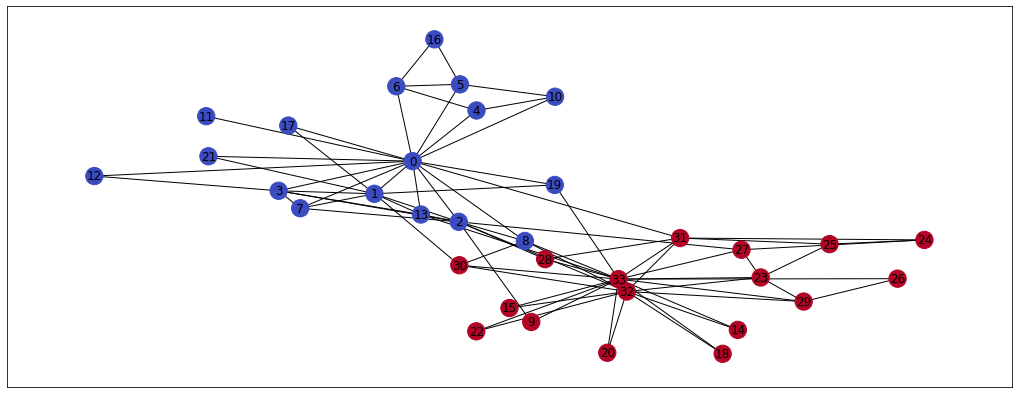

In [4]:
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

Nous pouvons voir les noeuds sont colorés selon les clubs, et on  voit bien que les membres d'un même clubs sont principalement liés à l'exception de quelques uns

In [5]:
model = DeepWalk(dimensions=124)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


Nous avons representé  chaque membre du club par un vecteur de 124.
Maintenant, reduisons cette dimension à 2 pour ensuite representer dans le plan (x,y).

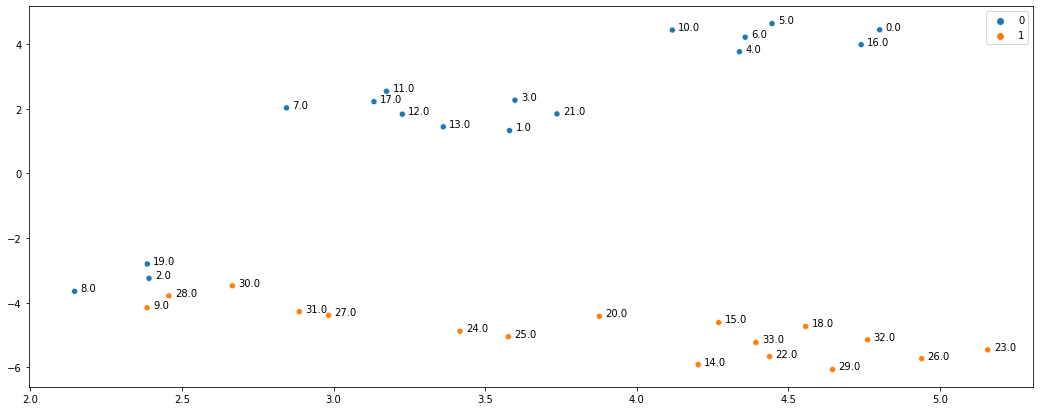

In [15]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))

Comme on le voit dans la figure, les plongements ont très bien reussi. Non seulement les deux clubs de Karaté sont clairement séparés, en plus la connexion se trouve au milieu
c'est à dire les points 8.0,9.0, 19.0, 28.0, 31.0 et 30.0.
Pour résumer, DeepWalk (et tout autre algorithme d'intégration de nœuds basé sur le voisinage) représente les nœuds sous forme de vecteurs qui capturent certaines informations de voisinage à partir du graphe.

### Marche Aléatoire
La marche aléatoire est une séquence de nœuds, où le nœud suivant est choisi au hasard parmi les nœuds adjacents. Par exemple, commençons notre marche aléatoire à partir du nœud 25. Dans le graphe ci-dessus, nous pouvons voir que le nœud 25 (le plus à droite) est connecté aux nœuds 24 et 31. Par conséquent, en utilisant un coin-flip(pile ou face biaisé), nous déterminerons où nous allez ensuite. Si nous sommes arrivés au nœud 24, nous pouvons voir qu'il est connecté aux membres 23, 27 et 31. Encore une fois, nous devons choisir au hasard où aller ensuite. Cette « marche » se poursuit jusqu'à ce que nous ayons atteint la longueur de marche souhaitée. 
En dessous une fonction simple pour implémenter cela dans le code.

In [16]:
def random_walk(start_node, walk_length):
    walk = [start_node]  # starting node
    
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  # get all neighbours of the node
        next_node = np.random.choice(all_neighbours, 1)[0]  # randomly pick 1 neighbour
        walk.append(next_node)  # append this node to the walk
        start_node = next_node  # this random node is now your current state
    
    return walk

Steps in random walk: [6, 16, 5, 10, 10, 0, 7, 1, 3, 3, 2, 2, 27, 27, 33, 20, 20, 33, 9, 33, 18]


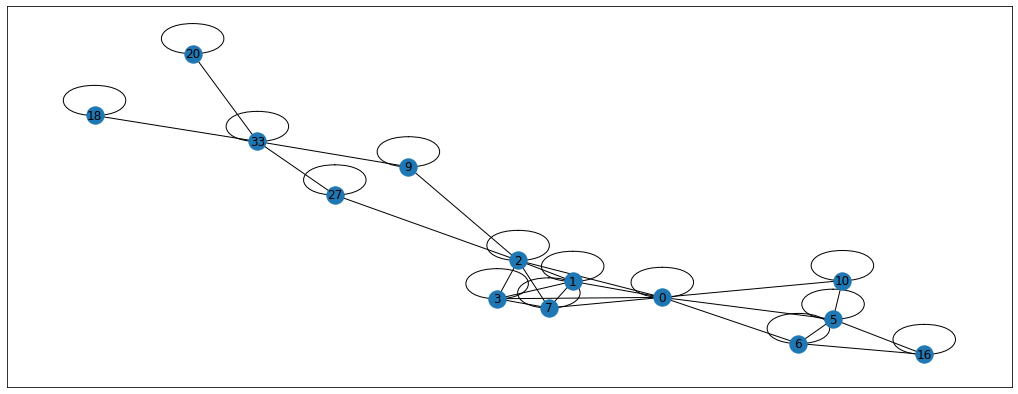

In [17]:
# Example use
walk = random_walk(6, 20)  # random walk from node 6
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

Nous avons donc généré une marche aléatoire d'une longueur de 20 à partir du noeud 6.
Vous pouvez suivre les étapes de cette marche sur le graphe ci-dessus et voir que chaque étape est située entre les points connectés.
En faisant cette marche, nous avons des informations utiles sur le contexte du noeud 6.
Nous connaissons donc maintenant que certains des voisins (et des voisins des voisins) du noeud 6 qui pourraient être utiles dans un problème de classification, par exemple.
En répétant cette marche aléatoire plusieurs fois pour tous les noeuds du graphe, nous pouvons obtenir un tas de séquences de « marche » contenant des informations utiles.
Le document suggère de faire environ 10 promenades par noeud avec une longueur de marche de 80.
Nous pourrions implémenter cela avec 2 boucles for mais, heureusement pour nous, karateclubpackage a déjà implémenté cela pour nous (et c'est beaucoup plus rapide).
Voici comment vous obtiendriez les marches aléatoires en 2 lignes de code.

Steps in random walk: [6, 16, 5, 10, 10, 0, 7, 1, 3, 3, 2, 2, 27, 27, 33, 20, 20, 33, 9, 33, 18]


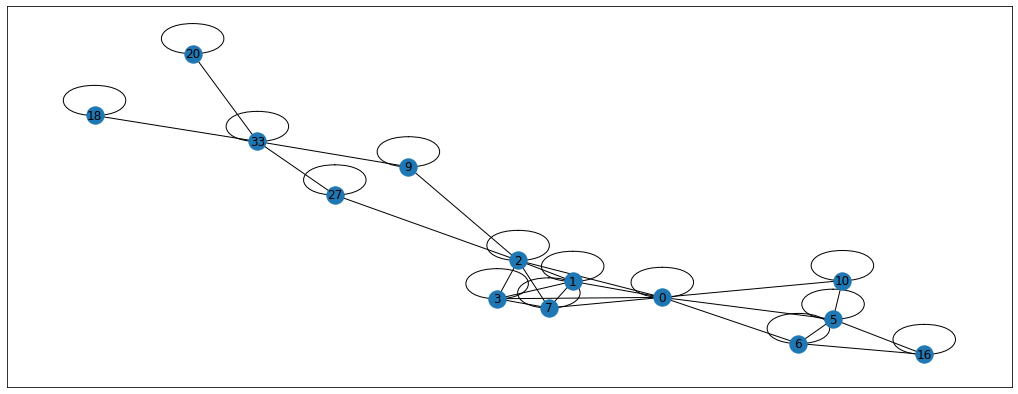

In [20]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)  # you can access the walks in walker.walks 
print('Steps in random walk:', walk)
walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

### Skip-Gram (Plongement)
Comment obtenir des plongements siginficatifs en utilisant les marches aéatoires générées ?
On pourrait utiliser l'algorithme Wor2Vect pour cela, ,en utilisant le modèle Skip-Gram avec une couche softmax hiérarchique.
L'idée principale du modèle skip-gram est de prédire le contexte d'une séquence à partir d'un noeud (ou d'un mot) particulier. 
Par exemple, si nous voulons former des intégrations pour le noeud 6 (exemple ci-dessus), nous formerons notre modèle (généralement un simple réseau neuronal dense) dans le but de prédire les noeuds qui apparaissent dans ses marches aléatoires. 
Ainsi, l'entrée du modèle sera le noeud 6 (encodé à chaud), la couche intermédiaire sera l'intégration réelle et la sortie sera la prédiction du contexte du noeud. 

In [25]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)

embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


### Classification sur les données de Facebook

Les données Facebook peuvent être téléchargées à partir du dépôt de l' ensemble de données(https://archive.ics.uci.edu/ml/machine-learning-databases/00527/).
Cet ensemble de données particulier est un réseau de pages Facebook. 
il y a 3 fichiers - liens, cibles et fonctionnalités.

#### Données

Ce webgraph est un graphe page-page des sites Facebook vérifiés. Les noeuds représentent les pages Facebook officielles tandis que les liens sont des likes mutuels entre les sites. Les fonctionnalités des noeuds sont extraites des descriptions de site que les propriétaires de page ont créées pour résumer l'objectif du site. Ce graphe a été collecté via l'API Facebook Graph en novembre 2017 et limité aux pages de 4 catégories définies par Facebook. Ces catégories sont : les politiciens, les organisations gouvernementales, les émissions de télévision et les entreprises. La tâche liée à cet ensemble de données est la classification multi-classes des nœuds pour les 4 catégories de sites.

In [43]:
path='D:/DataScience/data/facebook_large/'
edges_path = path+'facebook_edges.csv'
targets_path = path+'facebook_target.csv'
features_path = path+'facebook_features.json'

In [45]:
edges = pd.read_csv(edges_path)
print(edges.head())

   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829


In [44]:
targets = pd.read_csv(targets_path)
targets.index = targets.id
targets.head()

,id,facebook_id,page_name,page_type
id,,,,
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [46]:
# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)

In [47]:
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

Facebook Graph avec DeepWalk

Nous construison un graphe de données 

In [51]:
# Read in Graph
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

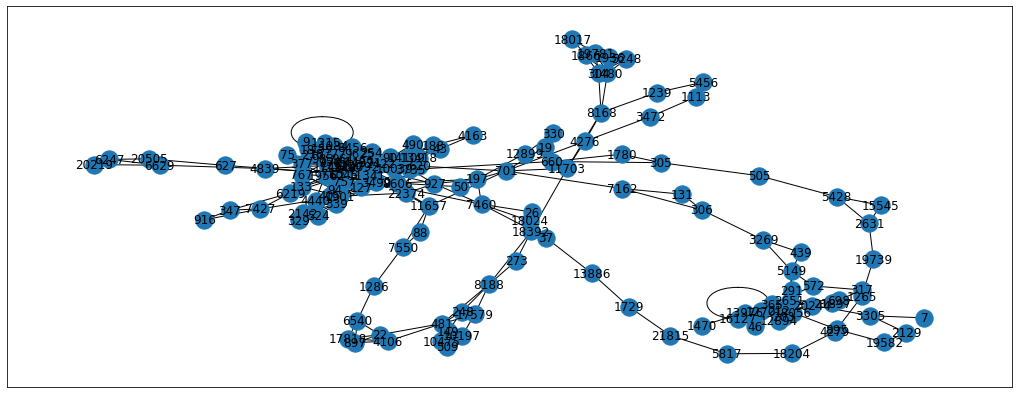

In [56]:
# Visualise some subgraph of 150 nodes
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))[:150] #Gets all the nodes in the graph that node 7 belongs to. 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

In [52]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

In [55]:
# Train Skip-Gram model
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

Le modèle DeepWalk est formé, nous pouvons donc utiliser les incorporations pour la classification. 
Nous pouvons rapidement vérifier le modèle en regardant les voisins les plus proches dans l'espace d'intégration de certaines pages Facebook.
Par exemple, vérifions les noeuds les plus similaires à la page Facebook d'American Express (ID 22196) et à l'émission Apprentice de la BBC (ID 451)

In [57]:
similar_to = '22196' # For American Express
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
22196,22196,205251616243022,American Express,company
22259,22259,145708245450216,American Express Japan,company
10663,10663,172586372790813,American Express Hong Kong,company
12287,12287,168312979854782,American Express,company
16984,16984,117495044948602,American Express אמריקן אקספרס,company


In [58]:
similar_to = '451' #For BBC
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
451,451,104667776288021,BBC Apprentice,tvshow
14787,14787,127439507270196,BBC Breakfast,tvshow
1429,1429,100865096953196,BBC Archive,tvshow
926,926,408902742628123,BBC Watchdog,tvshow
6372,6372,187828841236742,Merlin – Official,tvshow


Comme on peut constater, les voisins les plus proches sont incroyablement similaires aux pages d'origine et tout cela est réalisé sans même savoir de quoi parlent les pages d'origine ! Par conséquent, les intégrations apprises par DeepWalk sont significatives et nous pouvons les utiliser dans le classificateur. Nous pouvons construire un modèle de forêt aléatoire simple pour voir quelles performances nous pouvons atteindre uniquement en utilisant les intégrations.

In [59]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) 

# Train RF model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9354695149087673
[[9.48003014e-01 3.61718161e-02 3.01431801e-03 1.28108515e-02]
 [1.71769978e-02 9.57430919e-01 2.46452577e-02 7.46825990e-04]
 [5.08474576e-03 4.74576271e-02 9.46610169e-01 8.47457627e-04]
 [1.12654321e-01 1.54320988e-02 2.77777778e-02 8.44135802e-01]]


Les performances sont vraiment bonnes avec un score F1 d'environ 0,93. Nous pouvons essayer d'améliorer un peu plus les performances en utilisant une stratégie d'échantillonnage différente dans la marche aléatoire décrite dans l'article sur l'algorithme Node2Vec .

Facebook Graph avec Node2Vect

Node2Vec est très similaire à DeepWalk, mais les marches aléatoires sont générées un peu différemment.
Rappelons que dans la marche aléatoire pure, les noeuds de voisinage ont une probabilité égale d'être choisis comme prochaine étape.
Ici, à la place, nous avons 2 hyperparamètres à régler - p et q. 
p et q contrôle la vitesse à laquelle la marche explore et quitte le voisinage du noeud de départ u.
p --> une valeur élevée signifie que nous sommes moins susceptibles de revenir au nœud précédent.
q --> une valeur élevée se rapproche de la largeur de recherche en premier, ce qui signifie que le voisinage autour du noeud est exploré.
Les valeurs faibles donnent plus de chances de sortir du quartier et se rapprochent donc de la recherche en profondeur en premier.



Voici le bloc de code du package karate-club qui effectue la marche aléatoire biaisée. 

In [60]:
def biased_walk(start_node, walk_length, p, q):
    walk = [start_node]
    previous_node = None
    previous_node_neighbors = []
    for _ in range(walk_length-1):
        current_node = walk[-1]  # currnet node ID
        current_node_neighbors = np.array(list(graph.neighbors(current_node)))  # negihbours of this node
        probability = np.array([1/q] * len(current_node_neighbors), dtype=float)  # outwards probability weight determined by q
        probability[current_node_neighbors==previous_node] = 1/p  # probability of return determined by p
        probability[(np.isin(current_node_neighbors, previous_node_neighbors))] = 1  # weight of 1 to all the neighbours which are connected to the previous node as well
        norm_probability = probability/sum(probability)  # normalize the probablity
        selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]  # select the node from neighbours according to the probabilities from above
        walk.append(selected)  # append to the walk and continue
        previous_node_neighbors = current_node_neighbors
        previous_node = current_node
    
    return walk

Comparons 2 scénarios extrêmes :

p = 10, q = 0,1 --> ici, nous nous attendons à ce que la marche aléatoire aille vers l'extérieur et explore également les clusters adjacents.
p = 0,1, q = 10 --> ici, nous nous attendons à ce que la marche aléatoire reste très locale et explore le voisinage autour du noeud de départ.

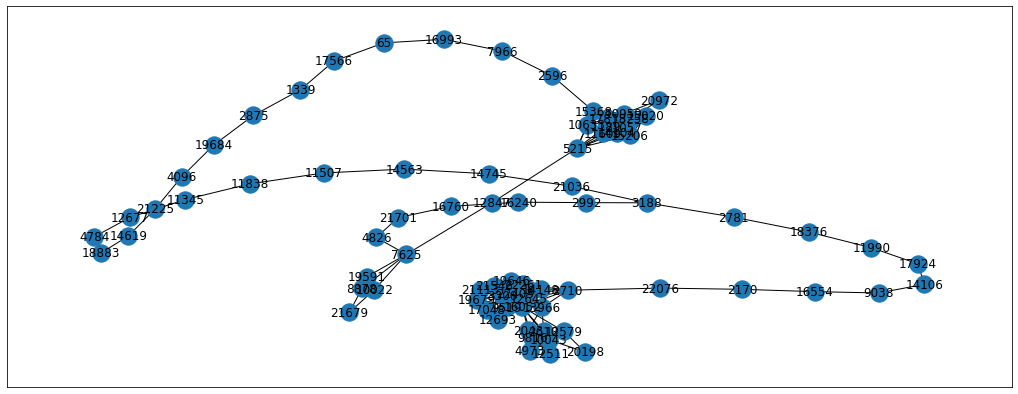

In [61]:
p = 10
q = 0.1
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

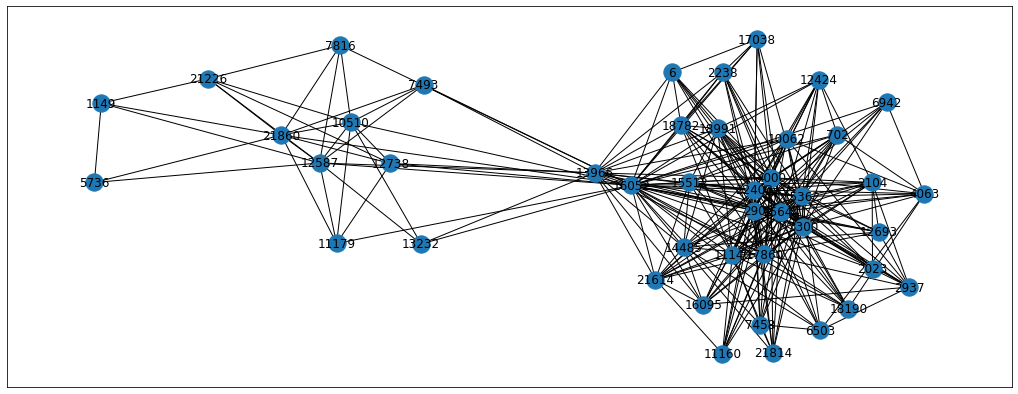

In [62]:
p = 0.1
q = 10
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7)) 
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

À partir des images, nous pouvons voir les différences entre les marches aléatoires résultantes.
Chaque problème aura ses propres paramètres parfaits p et q, nous pouvons donc les traiter comme des hyperparamètres à régler.
Pour l'instant, réglons simplement les paramètres sur p=0.5 et q=0.25.
De plus, nous allons utiliser l'implémentation karate-club de BiasedRandomWalker pour des raisons de simplicité. 
Veuillez noter que l'échantillonnage biaisé prend plus de temps à calculer, donc la recherche par grille des hyperparamètres optimaux est une longue procédure.

In [63]:
# Biased random walks
b_walker = BiasedRandomWalker(80, 10, 0.5, 0.25)
b_walker.do_walks(graph)

In [68]:
# Train skipgram
node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

In [69]:
# Get corresponding Node2Vec embeddings
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

In [70]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.2) # train/test split

In [71]:
# Train RF
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [72]:
print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9408099688473521
[[0.95587076 0.02285264 0.00551615 0.01576044]
 [0.01468531 0.95594406 0.02797203 0.0013986 ]
 [0.01046207 0.03225806 0.9537925  0.00348736]
 [0.08796296 0.02623457 0.0308642  0.85493827]]


Les résultats sont à peu près les mêmes, nous aurions donc besoin de faire une recherche de grille appropriée pour trouver les paramètres qui augmenteraient la précision.
Nous pouvons également utiliser UMAP pour tracer ces plongements et voir si les plongements diffèrent d'une manière ou d'une autre.

Comparaison DeepWalk vs Node2Vec

In [73]:
dw_micro_f1_scores = []
dw_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    dw_micro_f1_scores.append(mic)
    dw_macro_f1_scores.append(mac)

100%|██████████| 19/19 [04:29<00:00, 14.20s/it]


In [74]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 19/19 [04:35<00:00, 14.50s/it]


In [83]:
print(len(np.arange(0.1, 1, 0.1)))
print(len(dw_micro_f1_scores))
print(len(nv_micro_f1_scores))

9
19
19


[]

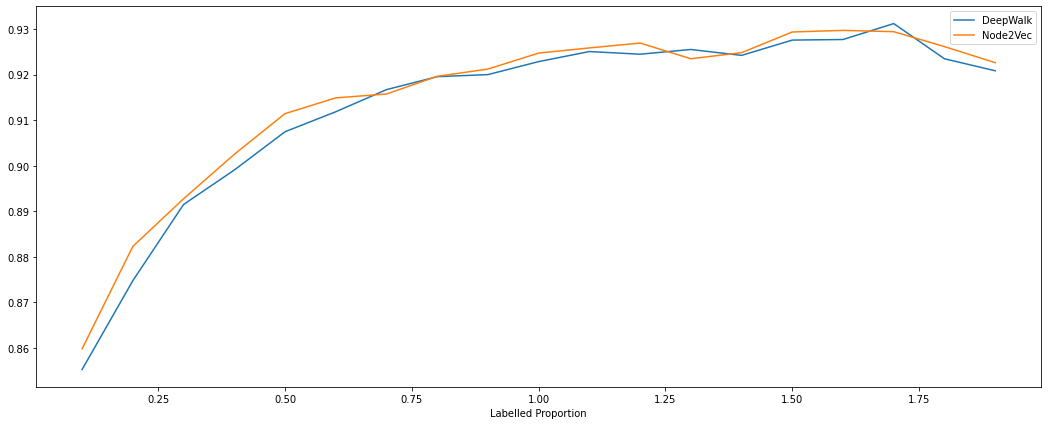

In [86]:
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = dw_micro_f1_scores, label='DeepWalk')
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = nv_micro_f1_scores, label='Node2Vec')
plt.xlabel('Labelled Proportion')
plt.plot()

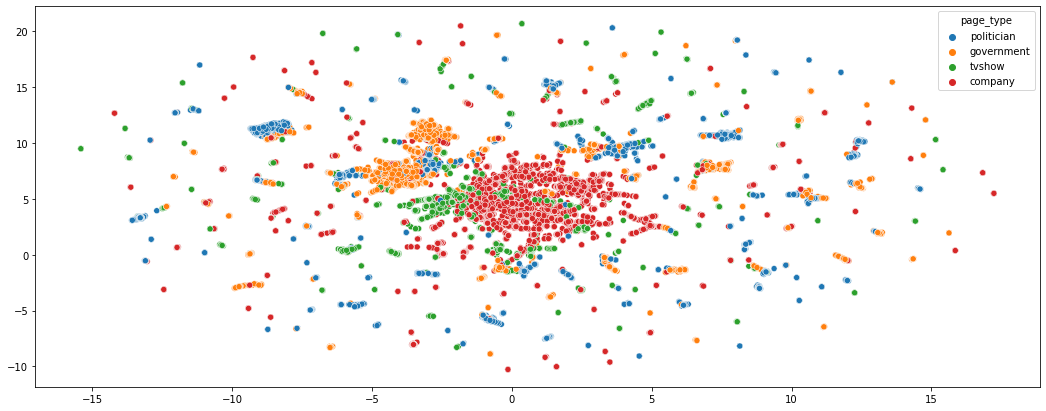

In [76]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)

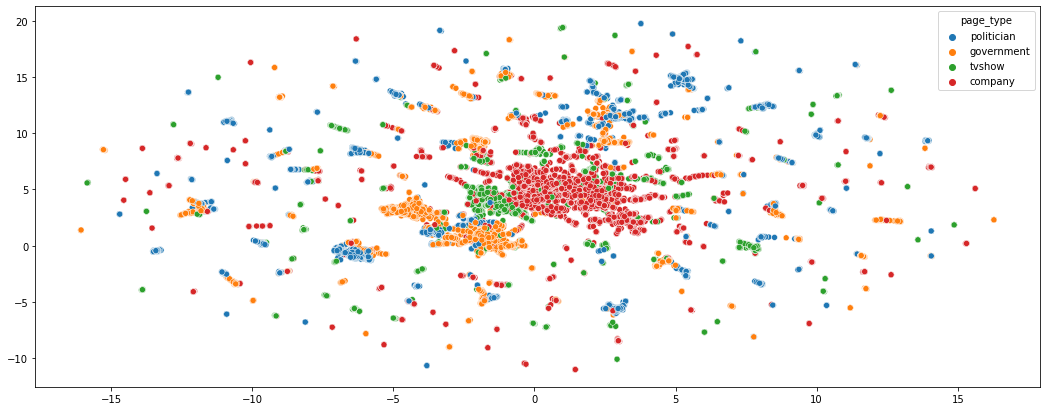

In [77]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)

ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)

Comme on peut le voir à partir des plongements, les company, governmentet tvshowssont représentés par des clusters clairs alors que les clusters politicianles sont dispersés. 
De plus, certaines pages ne sont pas regroupées, ce qui signifie qu'elles sont probablement beaucoup plus difficiles à classer.

### Conclusion
En utilisant simplement les informations de proximité des noeuds du graphe, nous avons pu extraire des incorporations de noeuds qui étaient incroyablement utiles dans la tâche de classification en aval.
Ici, on a vu deux algorithmes d'intégration de noeuds (DeepWalk et Node2Vec). 
Nous comprenons maintenant mieux le fonctionnement de ces algorithmes et comment les appliquer aux ensembles de données graphie du monde réel. 
De plus, nous avons couvert un aspect fondamental très important de la marche aléatoire et sa variante (la marche aléatoire biaisée).
Ces concepts sont cruciaux pour travailler avec des données graphes.